<a href="https://colab.research.google.com/github/Hajaarh/health_state_classifier/blob/main/health_state_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des bibliothèques nécessaires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, auc, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/bienetre.csv'

In [4]:
df = pd.read_csv(file_path)
df.head()

,target,age,taille,poids,revenu,experience,education,imc,stress,nb_enfants,depenses,exercice,alimentation,sommeil,pression,cholesterol,activite,satisfaction,risque,sante,bienetre
0,1,76.378818,172.472900,93.637574,2317.284189,23.187146,2.524067,24.544095,5.805570,1.0,1429.244924,4.0,6.128322,7.656376,129.058650,229.004516,4.483552,6.716421,46.007184,71.051570,4.829417
1,1,39.629339,162.527782,88.071856,2740.909189,26.742305,3.136856,26.805875,3.970287,1.0,1694.538136,1.0,6.068320,5.100178,121.038768,243.170215,4.908961,4.725666,42.880652,64.900618,5.994971
2,0,36.506832,196.457696,85.160759,3541.036636,20.895824,4.282662,24.218407,2.312967,0.0,3094.685811,3.0,6.503321,8.053128,108.250192,271.242294,7.003758,8.882047,23.152283,87.163500,8.123009
3,1,50.016190,174.829299,72.362368,3093.794975,26.155986,3.007974,23.452811,5.387465,0.0,1344.690334,3.0,6.015851,5.903230,124.828110,219.509215,4.570111,5.592381,51.413594,72.278489,6.326265
4,1,60.743330,171.536491,54.874865,2113.805284,14.771488,2.780533,26.065223,6.859302,1.0,1626.714555,3.0,5.344601,6.297733,117.464818,224.681593,5.145483,5.162349,47.531057,72.340850,4.493604


In [5]:
df.describe()

,target,age,taille,poids,revenu,experience,education,imc,stress,nb_enfants,depenses,exercice,alimentation,sommeil,pression,cholesterol,activite,satisfaction,risque,sante,bienetre
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.800000,47.978640,170.535341,74.042819,2796.214262,19.032658,3.299494,25.621232,4.598669,1.836000,1817.423785,2.626100,6.402255,7.195132,123.047003,204.035817,5.796017,6.393817,44.145412,73.824255,6.402144
std,0.748369,12.457695,10.114769,13.341103,781.533488,6.242550,0.779620,3.380089,1.807880,1.217396,533.266594,1.543353,1.804730,1.231426,12.549389,30.366382,2.163302,1.789406,24.605016,17.215520,1.797726
min,0.000000,7.587327,129.436247,31.449135,275.978543,-6.476955,1.000000,16.595884,-0.817043,0.000000,-124.882200,0.000000,1.000000,2.773131,79.364067,113.800424,1.000000,1.000000,0.000000,16.932014,0.699666
25%,0.000000,39.405573,163.740683,64.729830,2204.563230,14.697224,2.718558,23.240084,3.197705,1.000000,1458.848280,1.000000,5.101108,6.369437,114.360830,181.995873,4.113038,5.129324,23.080978,60.948984,5.114500
50%,1.000000,47.619796,170.490729,73.192735,2757.064229,18.971618,3.278090,25.314537,4.489886,2.000000,1817.829518,3.000000,6.502440,7.214413,122.755603,202.548092,5.651046,6.484931,43.577995,76.565336,6.499488
75%,1.000000,56.637883,177.275880,82.251508,3381.817122,23.292222,3.890786,27.579416,5.882468,3.000000,2185.951470,4.000000,7.805253,8.051258,131.595146,225.125376,7.684186,7.766372,60.885159,88.778946,7.787756
max,2.000000,93.773829,214.790843,140.374368,5363.916672,40.327629,5.000000,40.608144,10.605591,7.000000,3847.270156,8.000000,10.000000,11.331989,167.334076,305.815869,10.000000,10.000000,100.000000,100.000000,10.000000


# Prétraitement des données


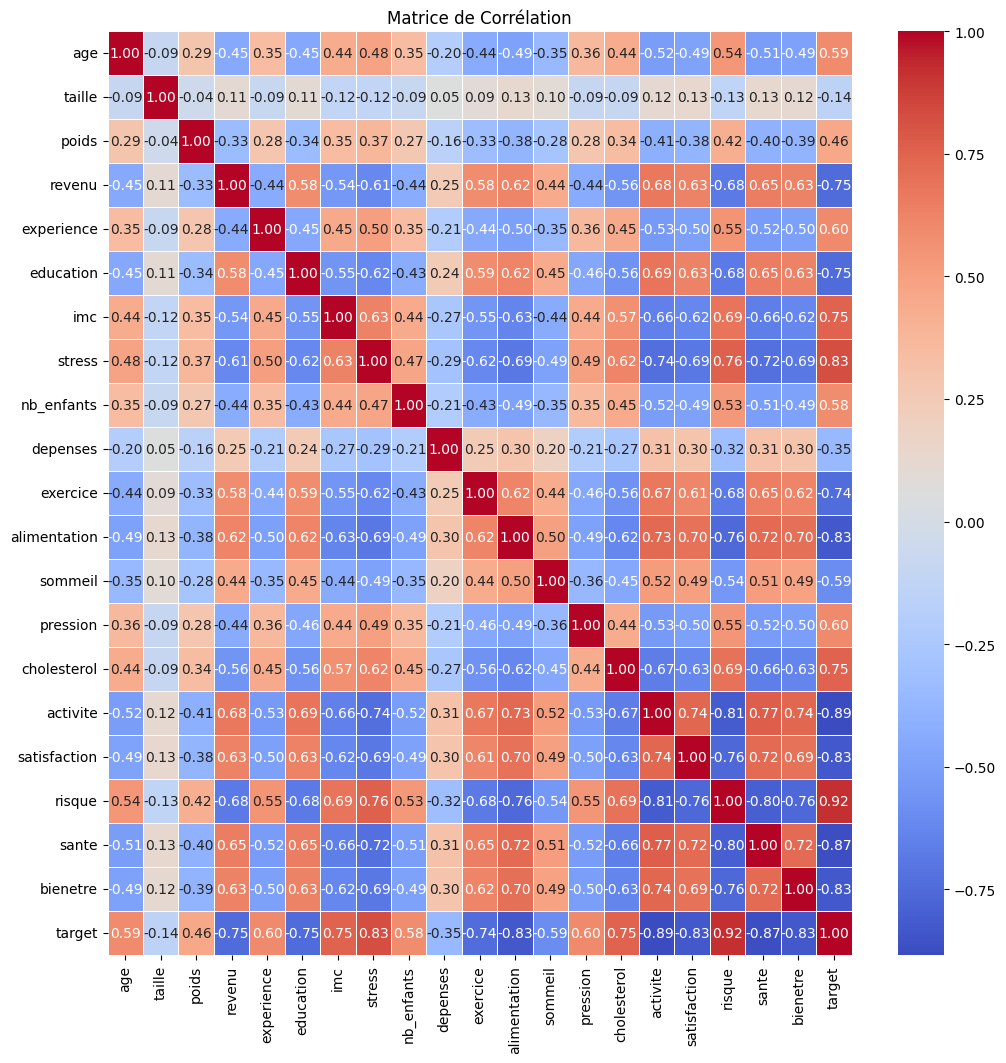

In [33]:
# Séparation des variables explicatives et de la cible
variables_explicatives = df.drop(columns=['target'])

# Appliquer la standardisation
standardiseur = StandardScaler()
df_standardized = pd.DataFrame(standardiseur.fit_transform(variables_explicatives), columns=variables_explicatives.columns)

# Réintégrer la colonne 'target' sans modification
df_standardized['target'] = df['target'].values

# Calcul de la matrice de corrélation après standardisation
matrice_correlation = df_standardized.corr()
# Calcul de la matrice de corrélation après standardisation
plt.figure(figsize=(12, 12))
sns.heatmap(matrice_correlation, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()


# Réduction de dimension avec PCA

In [35]:
# PCA pour réduction de dimension
pca = PCA(n_components=0.95)  # Conserver 95% de variance
X_pca = pca.fit_transform(df_standardized.drop(columns=['target']))


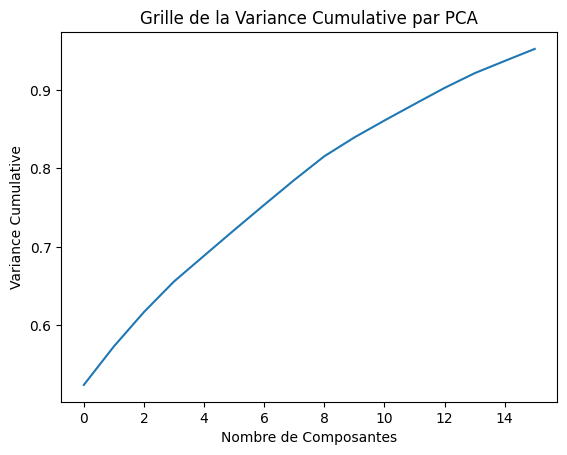

In [37]:
# Visualisation de la variance expliquée par chaque composante
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de Composantes')
plt.ylabel('Variance Cumulative')
plt.title('Grille de la Variance Cumulative par PCA')
plt.show()

In [36]:
# Séparation en jeu d'entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X_pca, df_standardized['target'], test_size=0.2, random_state=42, stratify=df_standardized['target'])


# Modélisation Supervisée

In [28]:
# Régression Logistique avec validation croisée
log_reg = LogisticRegression()
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5)
print("Régression Logistique - Score moyen CV:", np.mean(cv_scores))

Régression Logistique - Score moyen CV: 0.999625


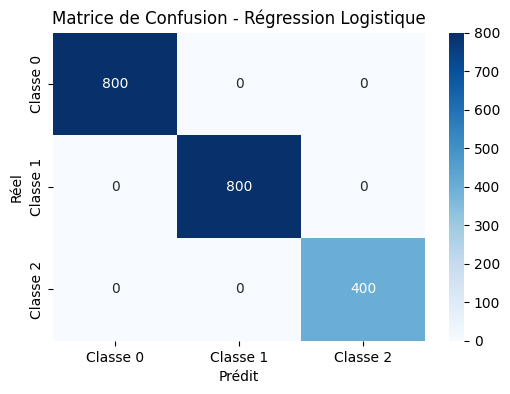

In [29]:
# Prédiction et matrice de confusion
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1', 'Classe 2'], yticklabels=['Classe 0', 'Classe 1', 'Classe 2'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion - Régression Logistique')
plt.show()

In [32]:
# Précision du modèle et rapport de classification
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Précision du modèle : 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       800
           1       1.00      1.00      1.00       800
           2       1.00      1.00      1.00       400

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000





> * Le modèle à classé correctement toutes les données du test, chaque métrique est à 1.00 ce qui confirme la perfommance du modèle.



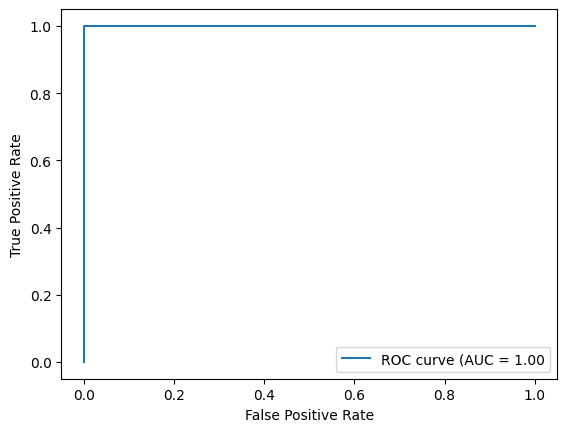

In [21]:
# Courbe ROC
y_probs = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



> * L'axe x représente le taux de faux positifs et l'axe y représente le taux de vrais positifs.
L'AUC est à 1 ce qui siginifie que notre modèle classe parfaitement les données.



# Visualisation du PCA

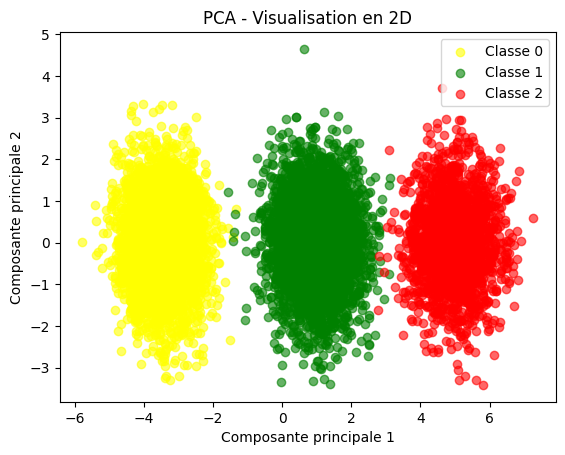

In [40]:
# Affichage du PCA en 2D
plt.figure()
colors = {1: 'green', 0: 'yellow', 2: 'red'}
for target_class in [0, 1, 2]:
    mask = df_standardized['target'] == target_class
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=colors[target_class], label=f'Classe {target_class}', alpha=0.6)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend()
plt.title('PCA - Visualisation en 2D')
plt.show()



> * Le graphique représente les données après la réduciton de dimension avec la PCA, avec les 2 premières composantes principales.
* Les points sont colorés selon la classe cible : Jaune(classe 0), Vert(classe 1), Rouge(classe 2).



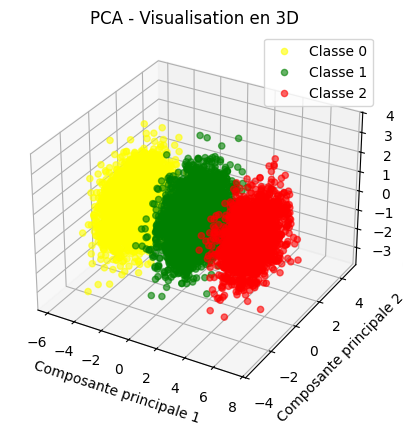

In [9]:
# Affichage du PCA en 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for target_class in [0, 1, 2]:
    mask = df_standardized['target'] == target_class
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2], c=colors[target_class], label=f'Classe {target_class}', alpha=0.6)
ax.set_xlabel('Composante principale 1')
ax.set_ylabel('Composante principale 2')
ax.set_zlabel('Composante principale 3')
ax.legend()
ax.set_title('PCA - Visualisation en 3D')
plt.show()

# Optimisation des modèles avec Grid Search

In [30]:
# KNN avec Grid Search valeurs impaires
param_grid = {'n_neighbors': list(range(1, 20, 2))}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Meilleur K pour KNN:", grid_search.best_params_)

Meilleur K pour KNN: {'n_neighbors': 5}




> * La recherche du meilleur K pour Knn après avoir testé des valeurs impaires de 1 à 19 est de 5. Signifiant que le modèle donne la meilleure performance en utilisant 5 voisins pour la classification.



In [13]:
# Arbre de décision avec Grid Search
param_grid = {'max_depth': range(1, 21), 'min_samples_leaf': range(1, 11)}
dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Meilleures hyperparamètres pour l'arbre de décision:", grid_search.best_params_)

Meilleures hyperparamètres pour l'arbre de décision: {'max_depth': 4, 'min_samples_leaf': 1}


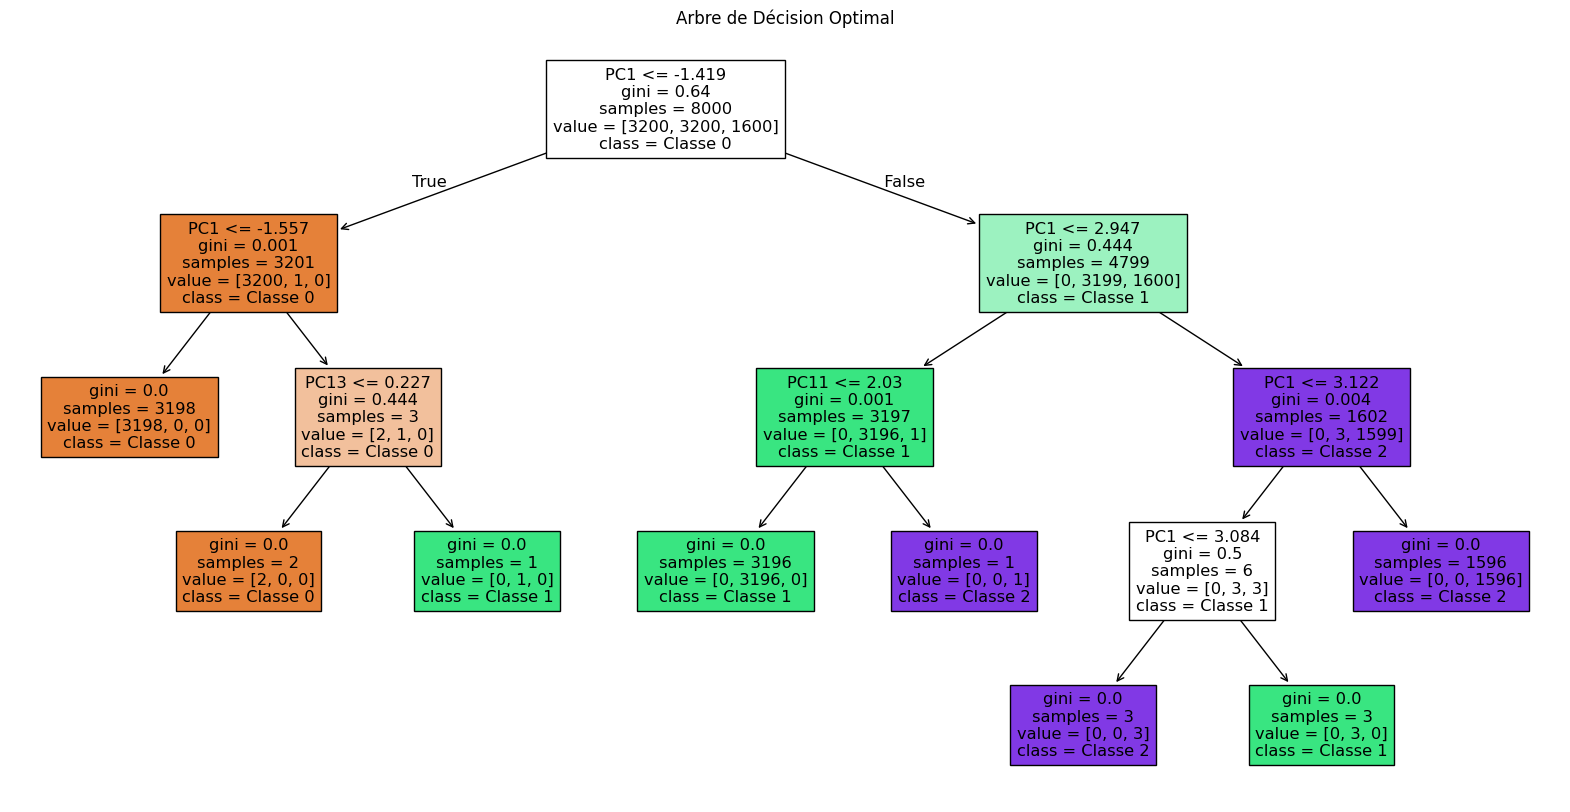

In [14]:
# Affichage de l'arbre de décision
dt_best = grid_search.best_estimator_
plt.figure(figsize=(20, 10))
plot_tree(dt_best, filled=True, feature_names=[f'PC{i+1}' for i in range(X_pca.shape[1])], class_names=['Classe 0', 'Classe 1', 'Classe 2'])
plt.title("Arbre de Décision Optimal")
plt.show()



> *  L’arbre semble bien structuré avec une séparation claire des classes.
* L’indice de Gini est faible ce qui signifie que chaque feuille contient presque uniquement une seule classe.
* L'arbre à une profondeur de maximale de 4 niveaux.



# Clustering non supervisé avec K-means

In [15]:
# K-Means avec méthode du coude
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

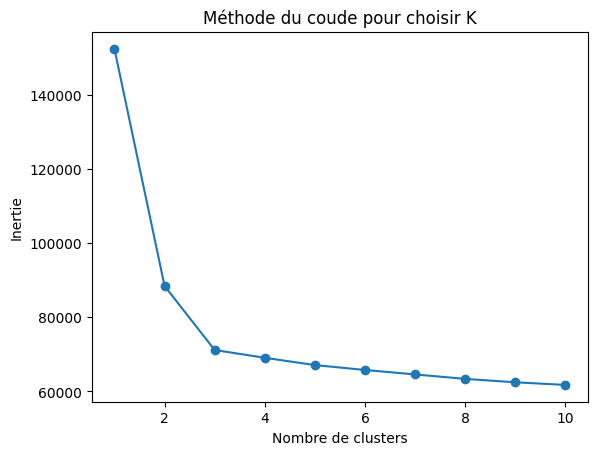

In [16]:
plt.figure()
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour choisir K')
plt.show()

> * On peut observer que l'inertie diminue fortement, ce qui siginifie que les clusters deviennent compact et bien séparés.
* Entre K3 et K4 la diminution devient lente et forme un coude dans la courbe.
* La méthode du coude suggère que 3 ou 4 clusters seraient une bonne option

